# 15 LoopStack

In [1]:
# default_exp loopstack

In [2]:
# export
from forgebox.loop import Loop,ProgressBar,Tolerate,Event,Stuff,chunkify
from types import MethodType
from datetime import datetime
import numpy as np
import pandas as pd
from time import sleep

To run through iterations quickly, we use the california housing data

In [3]:
from sklearn.datasets.california_housing import fetch_california_housing
x,y = fetch_california_housing(return_X_y = True)

x.shape, y.shape

((20640, 8), (20640,))

Normalized Data

Preview x input

In [4]:
def norm(m,s): return lambda x: (x-m)/s
def denorm(m,s): return lambda x: (x*s)+m

x_normed = norm(x.mean(0),x.std(0))(x)
y_normed = norm(y.mean(),y.std())(y)

x_normed = np.clip(x_normed,-2,2)
y_normed = np.clip(y_normed,-2,2)

In [5]:
x_normed.mean(0).astype(np.float16),x_normed.std(0),\
y_normed.mean().astype(np.float16),y_normed.std()

(array([-0.04333 ,  0.000478, -0.0397  , -0.04486 , -0.0554  , -0.01229 ,
        -0.007812,  0.001071], dtype=float16),
 array([0.85610596, 0.99901853, 0.53787672, 0.32598025, 0.73420682,
        0.09438235, 0.98221114, 0.99421595]),
 -0.0302,
 0.928904447452199)

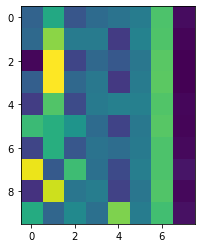

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(x_normed[np.random.choice(range(1000),10)])

In [7]:
x_normed

array([[ 2.        ,  0.98214266,  0.62855945, ..., -0.04959654,
         1.05254828, -1.32783522],
       [ 2.        , -0.60701891,  0.32704136, ..., -0.09251223,
         1.04318455, -1.32284391],
       [ 1.7826994 ,  1.85618152,  1.15562047, ..., -0.02584253,
         1.03850269, -1.33282653],
       ...,
       [-1.14259331, -0.92485123, -0.09031802, ..., -0.0717345 ,
         1.77823747, -0.8237132 ],
       [-1.05458292, -0.84539315, -0.04021111, ..., -0.09122515,
         1.77823747, -0.87362627],
       [-0.78012947, -1.00430931, -0.07044252, ..., -0.04368215,
         1.75014627, -0.83369581]])

In [8]:
# export
def create_event(event_name):
    class BatchEvent(Event):pass
    BatchEvent.__name__ = event_name
    return BatchEvent

def events(*enames):
    return list(map(create_event,enames))

In [9]:
# export
class LoopStack(Loop):
    settings = []
    """
    A stack of loop
    """
    @classmethod
    def from_loops(cls,*loops):
        def init(self,iterable=[],name = None):
            name = name if name!=None else cls.__name__
            
            self.loops = dict()
            l = Loop(iterable)
            for L in loops:
                l = L(iterable = l)
            super().__init__(iterable = l,
                             name = name)
            
            for stuff in cls.settings:
                self.make_stuff(stuff)
                
        setattr(cls,"init",init)
        return cls
    
    @classmethod
    def new_setting(cls,*settings):
        cls.settings+=list(settings)
    
    def make_stuff(self,name):
        new_stuff = Stuff(name)
        setattr(self.core,name,new_stuff)
        setattr(self,name,new_stuff)
    
    def __repr__(self,):
        return f"LoopStack>:{self.name}\n\t"+\
            "\n\t".join(map(str,self.core.layers[:-1]))

In [10]:
TRAIN_EVENTS = ["DATA_PROCESS","FORWARD","LOSS_CALC",
                "BACKWARD","OPT_STEP","METRICS"]
EVAL_EVENTS = ["DATA_PROCESS","EVAL_WRAP","FORWARD","LOSS_CALC","METRICS"]

## Tabulated Metrics

In [11]:
class MetricTab:
    def __init__(self):
        self.df_by_epoch = []
        self.mean_by_epoch = []
        self.refresh_list()
        
    def __add__(self,row):
        self.results.append(row)
        return self
    
    def summary(self):
        """The summary on metrics"""
        return pd.DataFrame(self.mean_by_epoch)
    
    def update(self,**batch):
        self.batch.append(batch)
        return self
    
    def result_df(self):
        return pd.DataFrame(self.results)
    
    def batch_df(self):
        return pd.DataFrame(self.batch)
    
    def refresh_list(self):
        self.batch = []
        self.results = []
        
    def calc_mean(self,result_df,batch_df):
        product_df = pd.DataFrame(dict((col,result_df[col]*batch_df["bs"]) for col in self.result_cols))
        batch_mean = dict()
        for col in self.result_cols:
            batch_mean[col] = product_df[col].sum()/batch_df["bs"].sum()
        batch_mean["epoch"] = len(self.mean_by_epoch)+1
        batch_mean["span"] = batch_df.ts.max()-batch_df.ts.min()
        return batch_mean
    
    def mark(self):
        result_df = self.result_df()
        batch_df = self.batch_df()
        
        self.result_cols = result_df.columns
        for col in self.result_cols:
            batch_df[col] = result_df[col]
            
        batch_mean = self.calc_mean(result_df,batch_df)
            
        self.df_by_epoch.append(batch_df)
        self.mean_by_epoch.append(batch_mean)
        
        self.refresh_list()
        
        return batch_df, batch_mean

In [12]:
metab = MetricTab()

In [13]:
for i in range(100):
    sleep(.01)
    metab+=dict(loss= np.random.rand()*(100-i))
    metab.update(i=i,epoch=i//5,bs = 32,ts = datetime.now())

In [14]:
batch_df,batch_mean = metab.mark()
display(batch_df)
batch_mean

,i,epoch,bs,ts,loss
0,0,0,32,2020-06-27 00:13:58.336637,77.890621
1,1,0,32,2020-06-27 00:13:58.348200,74.198538
2,2,0,32,2020-06-27 00:13:58.358385,16.766426
3,3,0,32,2020-06-27 00:13:58.369278,45.024939
4,4,0,32,2020-06-27 00:13:58.381860,34.455464
...,...,...,...,...,...
95,95,19,32,2020-06-27 00:13:59.442931,4.624593
96,96,19,32,2020-06-27 00:13:59.453216,2.810572
97,97,19,32,2020-06-27 00:13:59.465926,2.588210
98,98,19,32,2020-06-27 00:13:59.478903,0.560318


{'loss': 26.498444349723876,
 'epoch': 1,
 'span': Timedelta('0 days 00:00:01.155023')}

In [15]:
metab.summary()

,loss,epoch,span
0,26.498444,1,00:00:01.155023


In [23]:
# export
def train_callbacks(loop):
    loop.core.metric_tab = MetricTab()
    
    @loop.every_start_FORWARD
    def switch_model_to_train(loop): loop.model("train")()
    
    @loop.on_DATA_PROCESS
    def opt_zero_grad(loop):loop.opt("zero_grad")()
        
    @loop.on_BACKWARD
    def opt_move(loop): 
        loop.loss("backward")()
        loop.opt("step")()
        
def eval_callbacks(loop):
    @loop.on_DATA_PROCESS
    def switch_model_to_eval(loop): loop.model("eval")()
        
def to_tensor(x):
    return torch.Tensor(x)
        
def simple_forward(metric_func = []):
    def simple_forward_cb(self):
        @self.on_DATA_PROCESS
        def set_xy(self):
            self.var.clear()
            self.var.x,self.var.y = self.element
            self.var.apply(to_tensor,scope = ["x","y"])()
            
        @self.on_FORWARD
        def forward_pass(self):
            y_ = self.model()(self.var.x)
            self.var.y_ = y_.popitem()[1][:,0]
            
        @self.on_LOSS_CALC
        def calculate_loss(self):
            losses =  self.loss_func()(self.var.y_,self.var.y)
            self.loss.update(losses)
            
        @self.on_METRICS
        def calcualte_metrics(self):
            # calculate metrics
            with torch.no_grad():
                metrics = self.metric_func()(self.var.y_,self.var.y)
                self.metric.update(metrics)
        
        @self.on_METRICS
        def to_item(self):
            # loop through metrics
            self.metric.update(self.loss.cases)
            dt = dict((k,v.item() if is_tensor(v) else v) \
                          for k,v in self.metric.cases.items())
            self.metric_tab+=dt
            self.pgbar_data(dt)
            
        @self.on_METRICS
        def save_batch_row(self):
            self.metric_tab.update(
                bs = self.var.x.size(0),
                epoch = self.epoch,
                i = self.i,
                ts = datetime.now()
            )
            
        @self.every_end_METRICS
        def show_metric(self):
            self.metric_tab.mark()
            summary =self.metric_tab.summary()
            try:
                from IPython.display import clear_output
                clear_output()
                display(summary)
            except:
                print(print(summary))
            
    return simple_forward_cb

def single_device(device):
    def single_device_callback(self):
        @self.on_DATA_PROCESS
        def var_to_device(self):
            self.var.apply("to")(device)
            
        @self.before_1st_FORWARD
        def model_to_device(self):
            self.model.apply("to")(device)
            
    return single_device

In [24]:
# export 
import torch
from torch import is_tensor

class TrainLoop(LoopStack):
    def __init__(self,data_iter,model=[],opt=[],loss_func=[],loss=[],hp=[],cuda=[], 
                 callbacks = [train_callbacks,],tolerate=True):
        loops = [ProgressBar,]
        if tolerate:
            loops.append(Tolerate)
        loops+=list(events(*TRAIN_EVENTS))
        self.from_loops(*loops)
        self.new_setting("model","var",
                         "opt","loss_func","loss",
                         "hp","cuda","metric_func","metric")
        self.init(data_iter,)
        for cb in callbacks:
            print(f"assigning callback {cb}")
            cb(self)
        
class EvalLoop(LoopStack):
    def __init__(self,data_iter,tolerate=True):
        loops = [ProgressBar,]
        if tolerate:
            loops.append(Tolerate)
        loops+=list(events(*EVAL_EVENTS))
        self.from_loops(*loops)
        self.new_setting("model","var",
                         "loss_func","loss",
                         "hp","cuda","metric_func","metric")
        self.init(data_iter,)
        
        @self.EVAL_FORWARD.downstream
        def torch_eval_wrap(self,func):
            with torch.no_grad():
                func()            

In [25]:
from torch import nn
import torch

data_list = list(zip(chunkify(x_normed),chunkify(y_normed)))

loop = TrainLoop(data_list,tolerate=False,
                 callbacks=[train_callbacks,
                            simple_forward([nn.MSELoss()])])
loop

assigning callback <function train_callbacks at 0x1a2d7c99e0>
assigning callback <function simple_forward.<locals>.simple_forward_cb at 0x1a2d7e2b00>


LoopStack>:TrainLoop
	layer🍰Loop
	layer🍰ProgressBar
	event🌏DATA_PROCESS
	event🌏FORWARD
	event🌏LOSS_CALC
	event🌏BACKWARD
	event🌏OPT_STEP
	event🌏METRICS

In [26]:
# loop.search()

In [27]:
loop.model.baseline = nn.Linear(8,1)
loop.loss_func.mse = torch.nn.MSELoss()
loop.metric_func.mae = torch.nn.L1Loss()
loop.opt.adam = torch.optim.Adam(loop.model.baseline.parameters())

In [28]:
loop.search()

interactive(children=(Text(value='', description='KeyWord'), Output()), _dom_classes=('widget-interact',))

In [29]:
for i in range(10):loop.run()

,mae,mse,epoch,span
0,0.793236,0.980813,1,00:00:02.143544
1,0.614251,0.597763,2,00:00:02.204130
2,0.532322,0.461204,3,00:00:02.131806
3,0.492559,0.406819,4,00:00:02.016984
4,0.469879,0.377455,5,00:00:02.194623
5,0.453884,0.356890,6,00:00:02.049320
6,0.441853,0.341606,7,00:00:02.064624
7,0.432821,0.330527,8,00:00:02.060480
8,0.426311,0.322731,9,00:00:02.138526
9,0.421742,0.317332,10,00:00:02.595590


In [30]:
from matplotlib import pyplot as plt

,mae,mse,epoch,span
0,0.793236,0.980813,1,00:00:02.143544
1,0.614251,0.597763,2,00:00:02.204130
2,0.532322,0.461204,3,00:00:02.131806
3,0.492559,0.406819,4,00:00:02.016984
4,0.469879,0.377455,5,00:00:02.194623
5,0.453884,0.356890,6,00:00:02.049320
6,0.441853,0.341606,7,00:00:02.064624
7,0.432821,0.330527,8,00:00:02.060480
8,0.426311,0.322731,9,00:00:02.138526
9,0.421742,0.317332,10,00:00:02.595590


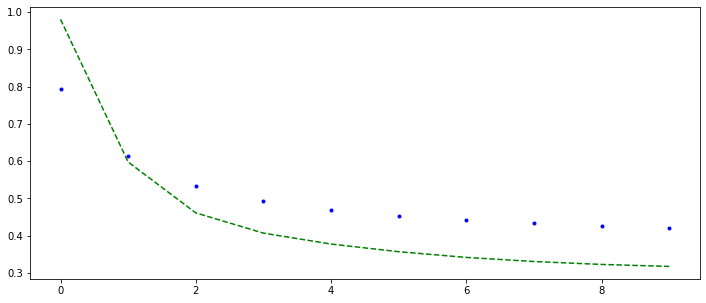

In [31]:
plt.figure(figsize = (12,5))
metric_df = loop.metric_tab.summary()
display(metric_df)
plt.plot(metric_df.mse,"g--",metric_df.mae,"b.")

In [19]:
loop.model

🍄:model[
	baseline
]

In [20]:
loop.loss_func

🍄:loss_func[
	mse
]

In [21]:
loop.metric

🍄:metric[
	mae
	mse
]

In [22]:
loop.metric.mse

tensor(0.1213, grad_fn=<MseLossBackward>)